In [33]:
import requests
import json
import prettytable
import pandas as pd
import datetime

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


#US bureu key is 

In [7]:
#Our objective is to extract the latest CPI data via The API of US Bureau of Labor Statistics
#And to identify the main contribution factors of recent surging. 

headers = {'Content-type': 'application/json'}

#Series identifies the categories/sub-categories of CPI indexes, for example CUUR0000SAF11 is the id for CPI index for food at home
#You can find the mappings between series and associated catagories at https://download.bls.gov/pub/time.series/cu/cu.item

data = json.dumps({"seriesid": ['CUUR0000SA0', 'CUUR0000SAF11', 'CUUR0000SEFV' ,'CUUR0000SACE', 'CUUR0000SEHF', 'CUUR0000SACL1E','CUUR0000SASLE'],"startyear":"2002", "endyear":"2022", 
                   "registrationkey":"upload_your_own_key"}) #You can obtain the registration key at https://data.bls.gov/registrationEngine/



#data = json.dumps({"seriesid": ['CUUR0000SAF11'],"startyear":"2011", "endyear":"2022", 
                   #"registrationkey":"f6ddb520602b492e927bd727277959bd"})
p = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', data=data, headers=headers)

#json response obtained 
json_data = json.loads(p.text)





In [9]:
#initial processing of json object and stores the data in pandas dataframe

result = list()
for series in json_data['Results']['series']:
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        value = item['value']
        date = datetime.date(year=int(year), month=int(period[-2:]), day=1)

        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            result.append((seriesId,year,period,value,date))

a = pd.DataFrame(result, columns=["series id","year","period","value","date"])


CUUR0000SA0
CUUR0000SAF11
CUUR0000SEFV
CUUR0000SACE
CUUR0000SEHF
CUUR0000SACL1E
CUUR0000SASLE


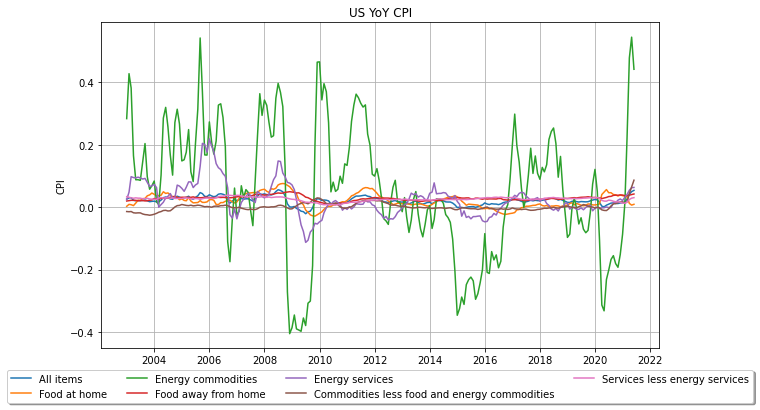

In [17]:
#Now lets plot the overall CPI, which is calculated based on a weighted sum of six sub-categories
#The sum of weights should be equal to 1
#Weights of the sub-categories can be found at 

#https://www.bls.gov/charts/consumer-price-index/consumer-price-index-relative-importance.htm

series = ['CUUR0000SA0', 'CUUR0000SAF11', 'CUUR0000SACE','CUUR0000SEFV' ,'CUUR0000SEHF', 'CUUR0000SACL1E','CUUR0000SASLE']

s_name = ['All items', 'Food at home', 'Energy commodities', 'Food away from home', 'Energy services', 
          'Commodities less food and energy commodities', 'Services less energy services' ]
s_weights = [1, 0.07647, 0.03929, 0.06226, 0.03144, 0.20473, 0.5858]

#the weights and the name of each series are built into a dictionary

name_dict = {}
weights_dict = {}
data_dict = {}
for i in range(len(series)):
    name_dict[series[i]] = s_name[i]
    weights_dict[series[i]] = s_weights[i]

    
#lets see if we can plot them
    
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Year')
ax.set_ylabel('CPI')
ax.set_title('US YoY CPI')
ax.grid(True)


# Plotting on the first y-axis
b = pd.DataFrame()
b["date"] = a[a['series id']== 'CUUR0000SA0']["date"]
for s in series:
    if s != "":
        
        #not you need to calculate YoY CPI percentage increase using .pct_change
        data_dict[s] = a[a['series id']== s]["value"].astype(float).pct_change(periods=-12)


        ax.plot(b["date"], data_dict[s], label=name_dict[s])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=4)

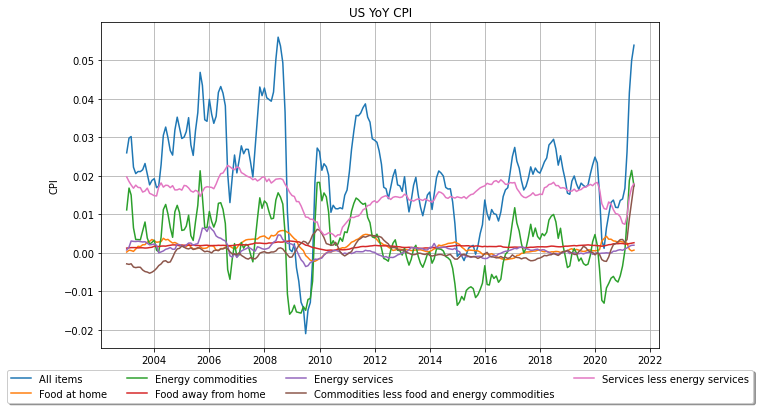

In [18]:
#Notice the graph above, each subcategory was plotted without the weights, so it is hard to see the percentage increase of other
#sub-categories, as the severe price movements of energy commodities dominated the series

#Now lets weight them

fig, ax = plt.subplots(figsize=(10, 6))

ax.set_xlabel('Year')
ax.set_ylabel('CPI')
ax.set_title('US YoY CPI')
ax.grid(True)


# Plotting on the first y-axis
b = pd.DataFrame()
b["date"] = a[a['series id']== 'CUUR0000SA0']["date"]
for s in series:
    if s != "":
        
        #not you need to calculate YoY CPI percentage increase using .pct_change
        data_dict[s] = a[a['series id']== s]["value"].astype(float).pct_change(periods=-12)*weights_dict[s]


        ax.plot(b["date"], data_dict[s], label=name_dict[s])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=4)

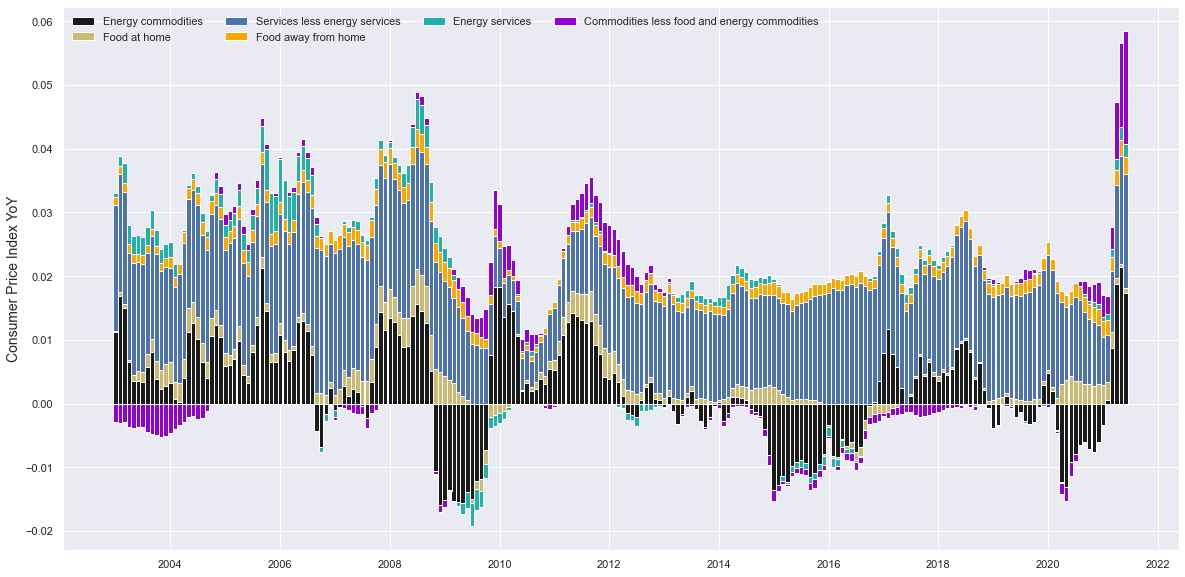

In [39]:
#Now it is much more clear but still quite messy, lets see if we could find more insights by using a stacked bargraph

series = ['CUUR0000SACE','CUUR0000SAF11','CUUR0000SASLE', 'CUUR0000SEFV' ,'CUUR0000SEHF', 'CUUR0000SACL1E']
s_name = ['Energy commodities','Food at home','Services less energy services',  'Food away from home', 'Energy services', 
          'Commodities less food and energy commodities' ]
s_weights = [0.03929,0.07647,0.5858,  0.06226, 0.03144, 0.20473]
sns.set_theme(style="darkgrid")

c = pd.DataFrame()
c['date']= b['date']
c["agr"] = 0

for s in series:
    c[s] = np.array(data_dict[s])
    c["agr"] += c[s]        
c = c.dropna()
fig, ax = plt.subplots(figsize=(20, 10))
ax.grid(True)

ax.set_ylabel('Consumer Price Index YoY', fontsize = 14)

temp = np.array(c[['CUUR0000SACE','CUUR0000SAF11','CUUR0000SASLE', 'CUUR0000SEFV' ,'CUUR0000SEHF', 'CUUR0000SACL1E']])
temp = temp.swapaxes(0,1)

def get_cumulated_array(data, **kwargs):
    cum = data.clip(**kwargs)
    cum = np.cumsum(cum, axis=0)
    d = np.zeros(np.shape(data))
    d[1:] = cum[:-1]
    return d 

cumulated_data = get_cumulated_array(temp, min=0)
cumulated_data_neg = get_cumulated_array(temp, max=0)
row_mask = (temp<0)
cumulated_data[row_mask] = cumulated_data_neg[row_mask]
data_stack = cumulated_data

data_shape = np.shape(temp)

cols = ["k", "y", "b", "orange", "lightseagreen", "darkviolet"]

for i in np.arange(0, data_shape[0]):
    ax.bar(c["date"], temp[i], bottom=data_stack[i], color=cols[i],width = 30)
plt.legend(s_name,  ncol=4, frameon=False)

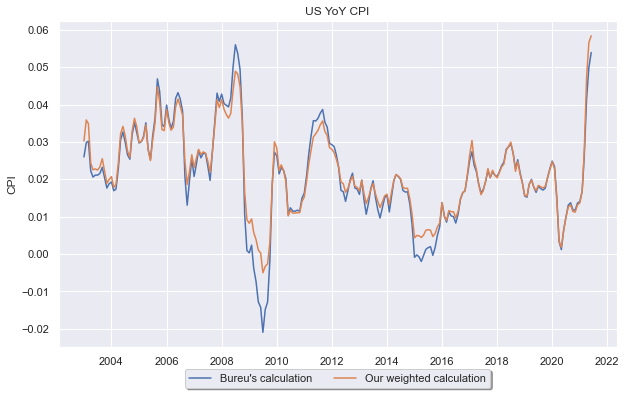

In [42]:
#Just to verify if our weighted calculation equals to the Bureau's own calculation
fig, ax = plt.subplots(figsize=(10, 6))
#axb = ax.twinx()

# Same as above
ax.set_xlabel('Year')
ax.set_ylabel('CPI')
ax.set_title('US YoY CPI')
ax.grid(True)

ax.plot(b["date"], data_dict["CUUR0000SA0"], label="Bureu's calculation")
ax.plot(c['date'], c["agr"], label="Our weighted calculation")

    #ax.plot(df.time, df.wind_gust, color='tab:olive', linestyle='--', label='Wind Gust')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=4)
#It's different slightly because the weights have been changed several times in the past, and will continue to change. 